Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Brain Tumor Segmentation with Swin UNETR (BraTS 21 Challenge)


This tutorial uses the [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) [1,2] model for the task of brain tumor segmentation using the [BraTS 21](http://braintumorsegmentation.org/) challenge dataset [3,4,5,6]. Swin UNETR ranked among top-performing models in the BraTS 21 validation phase. The architecture of Swin UNETR is demonstrated below

![swin_brats](https://github.com/Project-MONAI/tutorials/blob/main/figures/swin_brats21.png?raw=1)

The following features are included in this tutorial:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly rotate across each axes for data augmentation.
1. Randomly adjust the intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. Swin UNETR model, Dice loss function, Mean Dice metric for brain tumor segmentation task.

For more information access to pre-trained models and distributed training, please refer to Swin UNETR BraTS 21 official repository:

https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/BRATS21

## Data Description

Modality: MRI
Size: 1470 3D volumes (1251 Training + 219 Validation)  
Challenge: RSNA-ASNR-MICCAI Brain Tumor Segmentation (BraTS) Challenge

The dataset needs to be downloaded from the official BraTS 21 challenge portal as in the following

https://www.synapse.org/#!Synapse:syn27046444/wiki/616992

The JSON file containing training and validation sets (internal split) needs to be downloaded from this [link](https://drive.google.com/file/d/1i-BXYe-wZ8R9Vp3GXoajGyqaJ65Jybg1/view?usp=sharing) and placed in the same folder as the dataset. As discussed in the following, this tutorial uses fold 1 for training a Swin UNETR model on the BraTS 21 challenge.

### Tumor Characteristics

The sub-regions considered for evaluation in the BraTS 21 challenge are the "enhancing tumor" (ET), the "tumor core" (TC), and the "whole tumor" (WT). The ET is described by areas that show hyper-intensity in T1Gd when compared to T1, but also when compared to “healthy” white matter in T1Gd. The TC describes the bulk of the tumor, which is what is typically resected. The TC entails the ET, as well as the necrotic (NCR) parts of the tumor. The appearance of NCR is typically hypo-intense in T1-Gd when compared to T1. The WT describes the complete extent of the disease, as it entails the TC and the peritumoral edematous/invaded tissue (ED), which is typically depicted by the hyper-intense signal in FLAIR [[BraTS 21]](http://braintumorsegmentation.org/).

The provided segmentation labels have values of 1 for NCR, 2 for ED, 4 for ET, and 0 for everything else.

![image](https://github.com/Project-MONAI/tutorials/blob/main/figures/fig_brats21.png?raw=1)

Figure from [Baid et al.](https://arxiv.org/pdf/2107.02314v1.pdf) [3]



## References


If you find this tutorial helpful, please consider citing [1] and [2]:

[1]: Hatamizadeh, A., Nath, V., Tang, Y., Yang, D., Roth, H. and Xu, D., 2022. Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images. arXiv preprint arXiv:2201.01266.

[2]: Tang, Y., Yang, D., Li, W., Roth, H.R., Landman, B., Xu, D., Nath, V. and Hatamizadeh, A., 2022. Self-supervised pre-training of swin transformers for 3d medical image analysis. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 20730-20740).


### BraTS Dataset References

[3] U.Baid, et al., The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification, arXiv:2107.02314, 2021.

[4] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694

[5] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

[6] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_brats21_segmentation_3d.ipynb)

## Swin UNETR Model

The inputs to [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) are 3D multi-modal MRI images with 4 channels.
The patch partition block creates non-overlapping patches of the input data and projects them into embedding tokens with a resolution of 128x128x128.
The projected tokens are then encoded by using a 3D [Swin Transformer](https://openaccess.thecvf.com/content/ICCV2021/papers/Liu_Swin_Transformer_Hierarchical_Vision_Transformer_Using_Shifted_Windows_ICCV_2021_paper.pdf) in which the self-attention is computed within local windows.
The interaction between different windows is obtained by using 3D window shifting as illustrated below.

![image](https://github.com/Project-MONAI/tutorials/blob/main/figures/shift_patch.png?raw=1)

The transformer-based encoder is connected to a CNN-decoder via skip connection at multiple resolutions.
The segmentation output consists of 3 output channels corresponding to ET, WT, and TC sub-regions and is computed by using a 1x1x1 convolutional layer followed by Sigmoid activation function.


 ## Download dataset and json file

- Register and download the official BraTS 21 dataset from the link below and place them into "TrainingData" in the dataset folder:

  https://www.synapse.org/#!Synapse:syn27046444/wiki/616992
  
  For example, the address of a single file is as follows:
  
  "TrainingData/BraTS2021_01146/BraTS2021_01146_flair.nii.gz"
  

- Download the json file from this [link](https://drive.google.com/file/d/1i-BXYe-wZ8R9Vp3GXoajGyqaJ65Jybg1/view?usp=sharing) and placed in the same folder as the dataset.


## Setup environment

In [1]:
!pip install monai

  Using cached monai-1.3.1-py3-none-any.whl.metadata (10 kB)
Using cached monai-1.3.1-py3-none-any.whl (1.4 MB)


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-06-09 18:24:14.671283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!pip install einops

  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
Using cached einops-0.8.0-py3-none-any.whl (43 kB)


In [4]:
!pip install nibabel

  Using cached nibabel-5.2.1-py3-none-any.whl.metadata (8.8 kB)
Using cached nibabel-5.2.1-py3-none-any.whl (3.3 MB)


## Setup imports

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch

from torch.utils.data import Subset
import numpy as np

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

import logging
import boto3
from botocore.exceptions import ClientError

sess = sagemaker.Session()
role = get_execution_role()


print_config()

2024-06-09 18:24:43.599337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.0.0.post101
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 5.2.0
TorchVision version: 0.15.2a0+072ec57
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.31.0
mlflow version: NOT INSTALLED or UN

## Data Preparation

In [6]:
loc = "s3://swin-unetr-brains" # location of the dateset
channels = {"training": loc, "testing": loc}

## Setting up a Pytorch Training Job
[https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/pytorch_horovod_mnist/pytorch_mnist_horovod.html](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/pytorch_horovod_mnist/pytorch_mnist_horovod.html)

In [7]:
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.p3.2xlarge"

output_path = "s3://swin-unetr-brains/DEMO-swin/"

est = PyTorch(
    entry_point="trainer.py",
    source_dir="temp",  # directory of your training script
    role=role,
    framework_version="2.2.0",
    py_version="py310",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    hyperparameters={"batch-size": 1, "epochs": 50, "learning-rate": 1e-4, "log-interval": 100},
)

### Executing The Training Job (and passing in data channels)

In [9]:
est.fit(inputs=channels)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-05-03-16-43-32-902


2024-05-03 16:43:33 Starting - Starting the training job......
2024-05-03 16:44:07 Starting - Preparing the instances for training..

KeyboardInterrupt: 

### Location of Trained Model

In [3]:
# swin_model_data = est.model_data
# print("Model artifact saved at: \n", swin_model_data)
swin_model_data = "s3://swin-unetr-brains/DEMO-swin/pytorch-training-2024-05-02-19-52-45-737/output/model.tar.gz"

NameError: name 'est' is not defined

### Deploying The Trained Model to a Sagemaker Endpoint
[https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html)

In [9]:
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="temp",
    role=role,
    model_data=swin_model_data,
    framework_version="2.2.0",
    py_version="py310",
)

In [10]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c4.xlarge"
    # instance_type = "ml.p3.2xlarge"

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

-------!

### Testing The Deployed Inference Container With a Sample Test Input

In [7]:
case_num = "01619"
data_dir = "/home/sagemaker-user"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

In [12]:
print(predictor)

PyTorchPredictor: {'endpoint_name': 'pytorch-inference-2024-06-08-17-50-27-674', 'sagemaker_session': <sagemaker.session.Session object at 0x7f7a8b2f9ff0>, 'serializer': <sagemaker.base_serializers.JSONSerializer object at 0x7f7a8b2f80a0>, 'deserializer': <sagemaker.base_deserializers.JSONDeserializer object at 0x7f7a8b2fa5f0>}


In [14]:
res = predictor.predict(test_files)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (507) from primary with message "{
  "code": 507,
  "type": "InternalServerException",
  "message": "Worker died."
}
". See https://ca-central-1.console.aws.amazon.com/cloudwatch/home?region=ca-central-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-06-08-17-50-27-674 in account 420697970643 for more information.

In [ ]:
print("Predictions:", res)

### Visualizing The Predictions

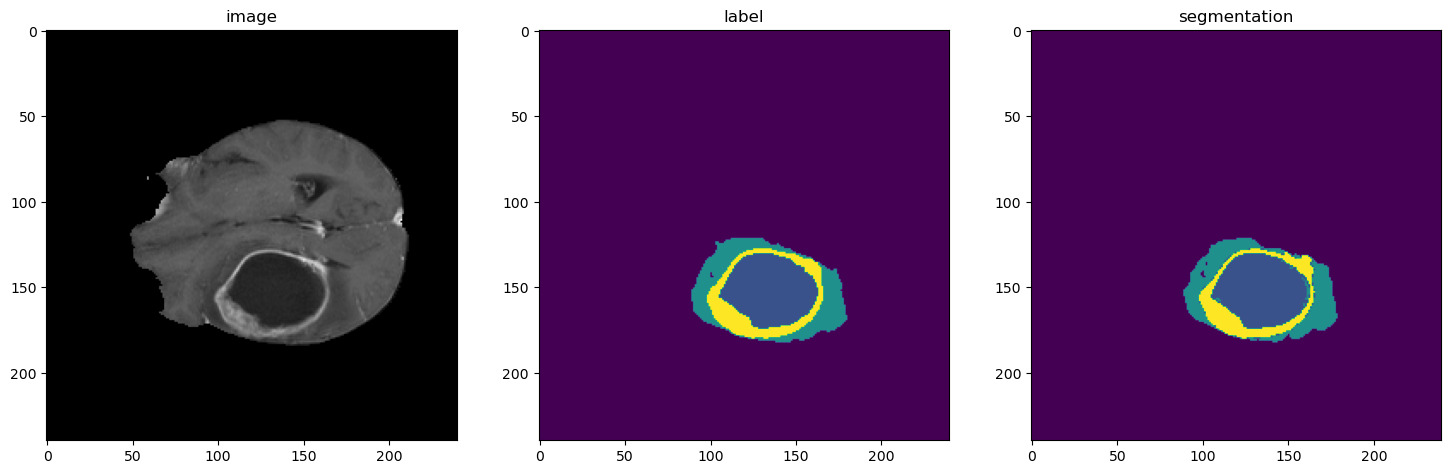

In [13]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()